In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
import scipy.stats as ss


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%config Completer.use_jedi = False

## either import the functions stored in agc.py or install from PyPI
from agc import * 


# Small random example

- We use this dataset first to compare various measures
- **N = 20,000** with 5% positive labels
- Bimodal distribution for the positive case

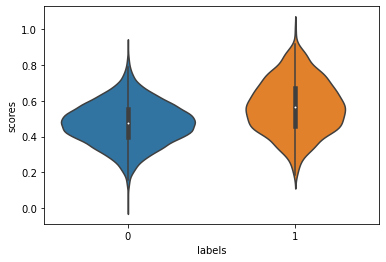

In [2]:
## labels
N = 20000
N_pos = 1000
labels = np.concatenate((np.repeat(1,N_pos),np.repeat(0,N-N_pos)))

## scores
scores = np.concatenate((np.random.normal(.75,.1,N_pos//5),np.random.normal(.45,.15,N_pos-N_pos//5),
                         np.random.normal(.4,.15,N-N_pos)))

## clumping
m = np.min(scores)
M = np.max(scores)
scores = [(i-m)/(M-m) for i in scores]
#scores = [min(1,i) for i in scores]
#scores = [max(0,i) for i in scores]

## plot
D = pd.DataFrame()
D['labels']=labels
D['scores']=scores
ax = sns.violinplot(x="labels", y="scores", data=D)

# ROC and AUC

- define 
 - TP: number of true positives
 - FP: false positives
 - TN: true negatives
 -FN: false negatives
 - TruePositiveRate: TPR = TP/(TP+FN)
 - FalsePositiveRate: FPR = FP/(FP+TN)
- ROC curve: plot TPR vs FPR for all possible thresholds
- AUC is the area under the ROC curve via trapezoidal rule
- For random ordering, expected AUC is R(AUC) = 0.5.
- Maximum value for AUC is: M(AUC)=1
- interpretation: AUC = Pr(score of random positive case > score of random negative case)
- Thus, one can easily approximate AUC even for huge datasets by sampling (with replacement) from positive cases, sampling (with replacement) negative cases and compare the samples.

We also define the **normalized AUC** as **AUC' = (AUC - R(AUC))/(M(AUC) - R(AUC)) = 2*AUC - 1**
so AUC' is the proportion of potential improvement over random that we achieved; this can be negative is we do worse than random.


In [3]:
## compute AUC
fpr, tpr, thresholds = roc_curve(np.array(labels), np.array(scores), pos_label=1)
AUC = roc_auc_score(np.array(labels), np.array(scores))
print('AUC=',AUC,'AUC\'=',(AUC-.5)/.5)

AUC= 0.6846270000000001 AUC'= 0.3692540000000002


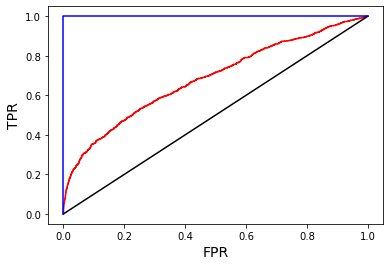

In [4]:
## plot ROC
## AUC = "area under red curve"
## AUC'= ("area under red curve"-"area under black curve")/("area under blue curve"-"area under black curve")
plt.plot(fpr,tpr,color='red')
plt.plot([0,1],[0,1],color='black')
plt.plot([0,0,1],[0,1,1],color='blue')
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14);

# Precision-recall (PR) curve and average precision (AP)

* recall = TP/(TP+FN)
* precision = TP/(TP+FP)
* we plot precision vs recall; result can be summarized via area under the curve using the trapeziodal rule; this is similar, but not the same as average precision (AP)
* AP = $\sum_i (R_i=R_{i-1})P_i$ where the $R_i$ are the recall values at the various thresholds, and $P_i$ the corresponding precision.
* Maximum value is 1, expected value under random classifier is the proportion of positive label points

We usually prefer using AP, as taking the area under the PR curve may be too optimistic. AP is generally preferable to AUC when dealing with class imbalance.


In [5]:
## Compute area(PR) and AP
precision, recall, _ = precision_recall_curve(np.array(labels), np.array(scores), pos_label=1)
print('Area under curve:',auc(recall, precision))
print('Average precision:',average_precision_score(np.array(labels), np.array(scores), pos_label=1))

Area under curve: 0.180800640568483
Average precision: 0.18134200152637092


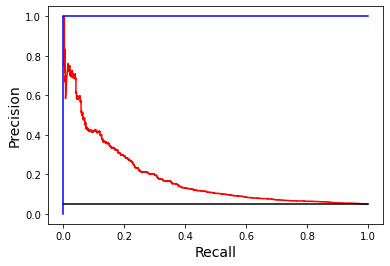

In [6]:
## plot PR curve in red; max in blue, rndom in black.
plt.plot(recall,precision,color='red')
plt.xlabel('Recall',fontsize=14)
plt.ylabel('Precision',fontsize=14);
plt.plot([0,1],[N_pos/N,N_pos/N],color='black')
plt.plot([0,0,1],[0,1,1],color='blue');


# Gain curves

For AUC or AP, we consider the entire curve. In practice, we may be very restricted in terms of the number of points we can look at, so we want as many positive cases to score high, say in the **top-k** or the **top (100*q)%**.

We can look at the precision for the top-k, but this neglects the ordering. One alternative is to look at **gain** curves. Let N be the total number of data points. We plot a gain curve by plotting: 

- for the x-axis: (TP+FP)/N, the proportion of points at or above the threshold, and
- for the y-axis: TPR.

Thus, is is simple to **truncate** a gain curve by looking only at the **top (100*q)%** scoring points as we show below.


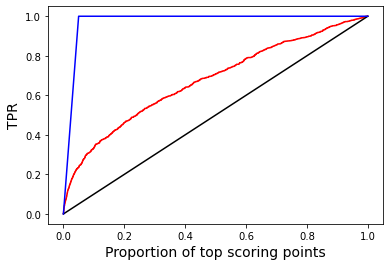

In [7]:
## plot gain curve as well as max and (expected) random curves
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=1)
plt.plot(top,tpr,'red')
plt.plot([0,1],[0,1],color='black') ## random
r = N_pos/N ## proportion of positives overall
plt.plot([0,r,1],[0,1,1],color='blue'); ## max
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

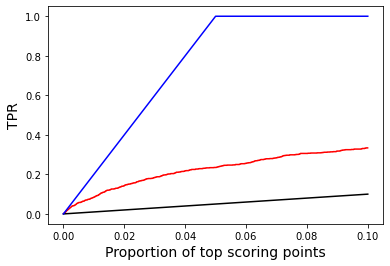

In [8]:
## partial gain curve - truncate at 10%
trunc = .1
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=trunc)
plt.plot(top,tpr,'red')
plt.plot([0,trunc],[0,trunc],color='black') ## random
r = N_pos/N ## proportion of positives overall
if r <= trunc:
    plt.plot([0,r,trunc],[0,1,1],color='blue') ## max
else:
    plt.plot([0,trunc],[0,N*trunc/N_pos],color='blue');
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

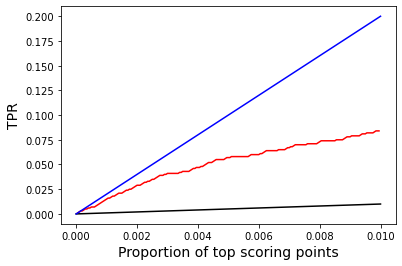

In [9]:
## partial gain curve - truncate at 1%
trunc = .01
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=trunc)
plt.plot(top,tpr,'red')
plt.plot([0,trunc],[0,trunc],color='black') ## random
r = N_pos/N ## proportion of positives overall
if r <= trunc:
    plt.plot([0,r,trunc],[0,1,1],color='blue') ## max
else:
    plt.plot([0,trunc],[0,N*trunc/N_pos],color='blue');
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

# AGC - area under the gain curve

Everything so far is well known. We now introduce the truncates score.

Consider the normalized area under the gain curve

**AGC'(q) = (AGC(q) - R(AGC(q)))/(M(AGC(q)) - R(AGC(q)))**

with the option of **truncating** the curve to the **top-(100q)%** scoring points.
There is also the option to have different **sample weights** for the data points. 

We wrote two functions to compute AGC or AGC':

```agc_score(y_true, y_score, pos_label=1, sample_weight=None, truncate=1, normalized=True)```

where parameter truncate = **q** for $q \le 1$; we can also pass an integer q>1 in which case we consider the top-q points

**Proposition**: AGC'(1) = AUC', i.e. when no truncation is done.

Finally, unlike AUC, the maximum value M(AGC)<1, so for the un-normalized area, we consider AGC/M(AGC) so that a perfect ordering yields a value of 1.


## Truncated AGC

In [10]:
## Recall tht AGC' = AUC' when no truncation is done, let's check
print("AGC':",agc_score(y_true=labels, y_score=scores, pos_label=1))
print("AUC':",(AUC-.5)/.5)

AGC': 0.369254
AUC': 0.3692540000000002


In [11]:
## AGC with truncation to top 10%, 1% and 200 (same as 1%)
print("AGC'(.1):",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=.1))
print("AGC'(.01):",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=.01))
print("AGC'(200):",agc_score(y_true=labels, y_score=scores, pos_label=1, truncate=200))


AGC'(.1): 0.24534214285714287
AGC'(.01): 0.48192105263157897
AGC'(200): 0.48192105263157897


## Weighted dataset

- we add random weights to all datapoints for testing
- default (unweighted) correponds to all weights == 1


In [12]:
## generate random weights 
W = 1+np.random.exponential(1,size=len(labels))

## compute weighted AUC
AUC = roc_auc_score(np.array(labels), np.array(scores), sample_weight=np.array(W))
print('AUC=',AUC,'AUC\'=',(AUC-.5)/.5)

AUC= 0.6823290795333756 AUC'= 0.36465815906675125


For weighted datasets, we can also sample to estimate AUC, but we need to take weighted sample.

- AUC = Pr(score for weighted sampled positive point > score for weighted sampled negative point)

In [13]:
## sample size
sample_size = 2000 ## 10%
## recall - first N_pos points are positive
w_pos = W[:N_pos]/np.sum(W[:N_pos])
w_neg = W[N_pos:]/np.sum(W[N_pos:])
s_pos = [scores[i] for i in np.random.choice(N_pos,size=sample_size,replace=True,p=w_pos)]
s_neg = [scores[i] for i in N_pos+np.random.choice(N-N_pos,size=sample_size,replace=True,p=w_neg)]
print('AUC approximation:',sum(np.array(s_pos)>np.array(s_neg))/sample_size)

AUC approximation: 0.674


We can also compute AGC with those weights; recall that AUC'=AGC'.

In [14]:
## weighted AGC
print('AGC = ',agc_score(labels, scores, sample_weight=W, normalized=False))
## weighted AGC' (this = AUC')
print("AGC'= ",agc_score(labels, scores, sample_weight=W, normalized=True))


AGC =  0.6905298020214026
AGC'=  0.36465815906675153


## Test: scores with ties

So far all scores are distinct; all computation still work with ties in scores, which we illustrate below by truncating the scores.


In [15]:
## force ties
sc = [int(x*1000)/1000 for x in scores]
print(len(np.unique(sc)),'distinct scores out of',len(sc))

## unweighted
print('unweighted')
AUC = roc_auc_score(np.array(labels), np.array(sc))
print('AUC =',AUC,'AUC\'=',(AUC-.5)/.5)
## weighted AGC
print('AGC =',agc_score(labels, sc, normalized=False),
      "AGC'=",agc_score(labels, sc, normalized=True))

## compute weighted AUC
print('weighted')
AUC = roc_auc_score(np.array(labels), np.array(sc), sample_weight=np.array(W))
print('AUC =',AUC,'AUC\'=',(AUC-.5)/.5)
## weighted AGC
print('AGC =',agc_score(labels, sc, sample_weight=W, normalized=False),
      "AGC'=",agc_score(labels, sc, sample_weight=W, normalized=True))


748 distinct scores out of 20000
unweighted
AUC = 0.6846364210526316 AUC'= 0.3692728421052631
AGC = 0.6927226666666667 AGC'= 0.3692728421052632
weighted
AUC = 0.6823353182329914 AUC'= 0.36467063646598286
AGC = 0.6905358796680524 AGC'= 0.3646706364659838


# To normalized or not to normalize 

We recommend using the normalized area, and here is an illustration justifying this.
Using the same example as before, we compare AGC for the whole curve and the top 1%,
both in normalized and un-normalized cases.

In the normalized case, the conclusion is that we do better early on than overall, which
is to be expected in view of the distribution for the positive case.

However, in the un-normalized case, the conclusion is the opposite ...

Looking at the curves once again, we see that for area under the black curve (random case) has a huge impact on the computation for AGC when looking at the whole dataset, but the impact is much less for the top 1%.
With the normalized version, we report the proportion of possible gain achieved over random, which we can naturally compare at various truncations.


In [16]:
## normalized agc, all data and top 1%
print('normalized AGC(1) = ',agc_score(labels, scores, normalized=True, truncate=1))
print('normalized AGC(.01) = ',agc_score(labels, scores, normalized=True, truncate=.01))


normalized AGC(1) =  0.369254
normalized AGC(.01) =  0.48192105263157897


In [17]:
## un-normalized agc, all data and top 1%
print('un-normalized AGC(1) = ',agc_score(labels, scores, normalized=False, truncate=1))
print('un-normalized AGC(.01) = ',agc_score(labels, scores, normalized=False, truncate=.01))

un-normalized AGC(1) =  0.6927134871794872
un-normalized AGC(.01) =  0.507825


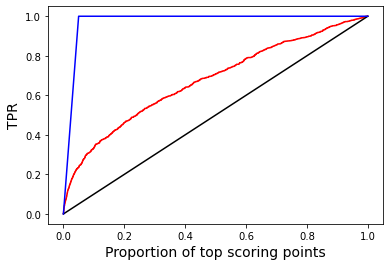

In [18]:
## plot gain curve as well as max and (expected) random curves
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, pos_label=1, truncate=1)
plt.plot(top,tpr,'red')
plt.plot([0,1],[0,1],color='black') ## random
r = N_pos/N ## proportion of positives overall
plt.plot([0,r,1],[0,1,1],color='blue'); ## max
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

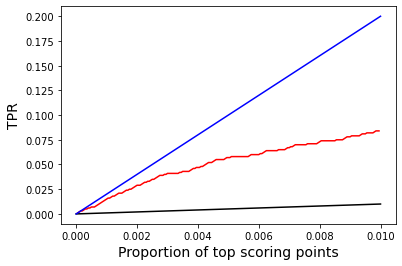

In [19]:
# partial gain curve - truncate at 1%
trunc = .01
top, tpr, _ = gain_curve(y_true=labels, y_score=scores, truncate=trunc)
plt.plot(top,tpr,'red')
plt.plot([0,trunc],[0,trunc],color='black') ## random
r = N_pos/N ## proportion of positives overall
if r <= trunc:
    plt.plot([0,r,trunc],[0,1,1],color='blue') ## max
else:
    plt.plot([0,trunc],[0,N*trunc/N_pos],color='blue');
plt.xlabel('Proportion of top scoring points',fontsize=14)
plt.ylabel('TPR',fontsize=14);

# Why not truncate AUC or AP?

For AUC, it is quite clear that truncating to the top $q$ points is problematic, since the x-axis is the FPR.
For example, if all top-$q$ points are positives (a great result!), the area is 0 ... If the first $q/2$ points 
are negatives followed by $q/2$ positives, we still have area 0 ... 

For AP, the x-axis are the recall values, so we can only truncate at threshold point that have at least a positive case. Let's see this via a simple example. We look at AP for the first 10 points. Consider 2 cases for the ranking (from high to low scores, no ties):
* 10 positives: AP(10) = 1 (precision of 1 everywhere)
* 3 positive followed by 7 negatives: AP(10) = 1 (since recall only changes at the first 3 points)

We look at a larger example below. We consider $n = 1000$ points, 100 of which are positives.
We look at the top-50, which contains 25 positives.
For the top-50, given $k \in \{0,1,...,25\}$, we set the top $k$ points and the bottom $25-k$ points as positives, the rest as negatives.

Below we compare the (normalized) AP with the normalized AGC. Normalization for AP is done in the same way we already described.

We clearly see that AP is being overly optimistic, not only in the extreme case where all 25 positives in the top-50 are ranked first, but overall.


In [20]:
## AP' for top-k
from sklearn.metrics import precision_recall_curve as prc
def normalized_AP(y_true, y_score, truncate):
    precision, recall, thresholds = prc(y_true, y_score)
    th = y_score[truncate-1]
    b = thresholds >= th
    AP = sum([precision[i]*(recall[i]-recall[i+1]) for i in range(len(b)) if b[i]])
    M = sum([(recall[i]-recall[i+1]) for i in range(len(b)) if b[i]])
    R = sum(y_true)/len(y_true)*M
    if M>0:
        return (AP-R)/(M-R)
    else:
        return None


In [21]:
n = 1000
pos = 100
k = 50
k_pos = 25
proba = np.linspace(1,0,n) ##  decreasing scores
L = []
for a in np.arange(0,k_pos+1):
    ## init
    y_true = np.repeat(0,n)
    ## k_pos in top k according to 'a'
    for i in range(a):
        y_true[i]=1
    for i in range(k-1,k-1-(k_pos-a),-1):
        y_true[i]=1
    ## pos-k_pos in bottom (n-k) at random
    for i in np.random.choice(n-k, pos-k_pos, False):
        y_true[i+k] = 1
    ap = normalized_AP(y_true, proba, truncate=k)
    agc = agc_score(y_true, proba, truncate=k)
    L.append([a,ap,agc])

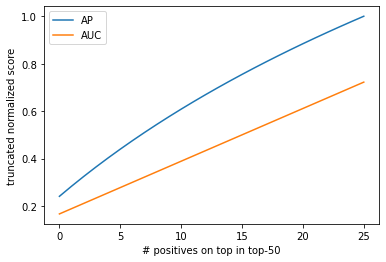

In [22]:
D = pd.DataFrame(L, columns=['top-positives','AP','AUC'])
plt.plot(D['top-positives'],D['AP'],label='AP')
plt.plot(D['top-positives'],D['AUC'],label='AUC')
plt.xlabel('# positives on top in top-50')
plt.ylabel('truncated normalized score')
plt.legend();


# Speed tests

AGC without sample weights is very fast; version with weights (when ```sample_weight``` is set) is slightly slower. We compare those below.


In [23]:
## 10M points, 10k positives, all in top 1% (100k)
import time

n = 10000000
pos = 10000
proba = np.linspace(1,0,n)
y_true = np.repeat(0,n)
for i in np.random.choice(n//100, pos, False):
    y_true[i] = 1
        

In [24]:
## AGC', no weights
start = time.time()
a = agc_score(y_true, proba, normalized=True, truncate=25000)
end = time.time()
print("AGC' =",a,' time =',end-start)

AGC' = 0.14993651330203442  time = 1.8882780075073242


In [25]:
## AGC' with weights (we set all to 1 to compare with result above)
w = np.repeat(1,n)
start = time.time()
a = agc_score(y_true, proba, normalized=True, truncate=25000, sample_weight=w)
end = time.time()
print("AGC' =",a,' time =',end-start)

AGC' = 0.14993651330203442  time = 3.8450100421905518
